## Import all required libraries

In [1]:
import sys
import os
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

import scipy.io
import time
from datetime import datetime
from pyDOE import lhs
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
tf.keras.backend.set_floatx('float32')

## Function to load dataset and bring to proper form for training

In [12]:
def prep_data(N_u=None, N_f=None):
    
    # Loading the dataset from .npy files
    t = np.load('time_new.npy')
    conc = np.load('Conc_new.npy')
    x = np.arange(1,129)#129
    y = np.arange(1,129)#129
    
    # Creating a meshgrid of all possible tuples of x, y, t
    xv,yv,tv = np.meshgrid(x,y,t,indexing='ij')
        
    # Preparing the inputs x , y and t (meshed as xv, yv and tv) for predictions in one single array, as inp_star
    inp_star = np.hstack((xv.flatten('F')[:,None], yv.flatten('F')[:,None],tv.flatten('F')[:,None]))

    # Preparing the testing conc_star
    conc_star = []
    for i in np.arange(inp_star.shape[0]):
        conc_star.append(conc[inp_star[i,0]-1,inp_star[i,1]-1,inp_star[i,2]-1])
    conc_star = np.asarray(conc_star)
    conc_star = conc_star.reshape((conc_star.shape[0],1))
    
    idx = np.random.choice(inp_star.shape[0], N_u, replace=False)
    inp_train = inp_star[idx,:]
    conc_train = []
    for i in np.arange(inp_train.shape[0]):
        conc_train.append(conc[inp_train[i,0]-1,inp_train[i,1]-1,inp_train[i,2]-1])
    conc_train = np.asarray(conc_train)
    conc_train = conc_train.reshape((conc_train.shape[0],1))
    
    # For the case when N_f is not given as input
    if N_f == None:
        lb = X_star.min(axis=0)
        ub = X_star.max(axis=0) 
        return x, t, X, T, Exact_u, inp_star, conc_star, inp_train, conc_train, ub, lb

    # Domain bounds (lowerbounds upperbounds) [x, y, t], which are here ([1, 1, 0] and [128, 128, 5000])
    lb = inp_star.min(axis=0)
    ub = inp_star.max(axis=0)
    # Getting the initial conditions (t=0)
    initial_cond = inp_star[0:128*128,:]#128*128
    conc_initial_cond = conc[:,:,0]
    conc_initial_cond = conc_initial_cond.flatten('F')[:,None]
    # Getting the all boundary conditions
    top_bound = inp_star[inp_star[:,0]==1]
    bottom_bound = inp_star[inp_star[:,0]==128]
    left_bound = inp_star[inp_star[:,1]==1]
    right_bound = inp_star[inp_star[:,1]==128]
    boundary_ind = np.vstack((top_bound,bottom_bound,left_bound,right_bound))
    
    conc_boundary = []
    for i in np.arange(boundary_ind.shape[0]):
        conc_boundary.append(conc[boundary_ind[i,0]-1,boundary_ind[i,1]-1,boundary_ind[i,2]-1])
    conc_boundary = np.asarray(conc_boundary)
    conc_boundary = conc_boundary.flatten('F')[:,None]
    
    ## Stacking them in multidimensional tensors for training (inp_train)
    #inp_train = np.vstack([initial_cond,boundary_ind])
    #conc_train = np.vstack([conc_initial_cond, conc_boundary])

    # Generating the x, y and t collocation points for f, with each having a N_f size
    # We pointwise add and multiply to spread the LHS over the 3D domain
    inp_f_train = lb + (ub-lb)*lhs(3, N_f)

    # Generating a uniform random sample from ints between 0, and the size of inp_train, of size N_u (initial data size) and without replacement (unique)
    idx = np.random.choice(boundary_ind.shape[0], N_u, replace=False)
    # Getting the corresponding inp_train (which is now scarce boundary and initial coordinates)
    boundary_ind_idx = boundary_ind[idx,:]
    # Getting the corresponding conc_train
    conc_boundary_idx = conc_boundary[idx,:]
    
    # Stacking them in multidimensional tensors for training (inp_train)
    inp_train = np.vstack([initial_cond,boundary_ind_idx])
    conc_train = np.vstack([conc_initial_cond, conc_boundary_idx])


    return x, y, t, xv, tv, yv, conc, inp_star, conc_star, inp_train, conc_train, inp_f_train, ub, lb


## Logger class implemented for error and loss analysis

In [4]:
class Logger(object):
    def __init__(self, frequency=10):
        print("TensorFlow version: {}".format(tf.__version__))
        print("Eager execution: {}".format(tf.executing_eagerly()))
        print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

        self.start_time = time.time()
        self.frequency = frequency

    def __get_elapsed(self):
        return datetime.fromtimestamp(time.time() - self.start_time).strftime("%M:%S")

    def __get_error_u(self):
        return self.error_fn()

    def set_error_fn(self, error_fn):
        self.error_fn = error_fn
  
    def log_train_start(self, model):
        print("\nTraining started")
        print("================")
        self.model = model
        print(self.model.summary())

    def log_train_epoch(self, epoch, loss, custom="", is_iter=False):
        if epoch % self.frequency == 0:
            print(f"{'nt_epoch' if is_iter else 'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e}  error = {self.__get_error_u():.4e}  " + custom)

    def log_train_opt(self, name):
        # print(f"tf_epoch =      0  elapsed = 00:00  loss = 2.7391e-01  error = 9.0843e-01")
        print(f"—— Starting {name} optimization ——")

    def log_train_end(self, epoch, custom=""):
        print("==================")
        print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()}  error = {self.__get_error_u():.4e}  " + custom)


## Additional Functional dependencies like L-BFGS etc

In [5]:
import tensorflow as tf
import numpy as np
import time

# Time tracking functions
global_time_list = []
global_last_time = 0
def reset_time():
    global global_time_list, global_last_time
    global_time_list = []
    global_last_time = time.perf_counter()
    
def record_time():
    global global_last_time, global_time_list
    new_time = time.perf_counter()
    global_time_list.append(new_time - global_last_time)
    global_last_time = time.perf_counter()
    #print("step: %.2f"%(global_time_list[-1]*1000))

def last_time():
    """Returns last interval records in millis."""
    global global_last_time, global_time_list
    if global_time_list:
        return 1000 * global_time_list[-1]
    else:
        return 0

def dot(a, b):
    """Dot product function since TensorFlow doesn't have one."""
    return tf.reduce_sum(a*b)

def verbose_func(s):
    print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, config, state, do_verbose, log_fn):
    """port of lbfgs.lua, using TensorFlow eager mode."""

    if config.maxIter == 0:
        return

    global final_loss, times

    maxIter = config.maxIter
    maxEval = config.maxEval or maxIter*1.25
    tolFun = config.tolFun or 1e-5
    tolX = config.tolX or 1e-19
    nCorrection = config.nCorrection or 100
    lineSearch = config.lineSearch
    lineSearchOpts = config.lineSearchOptions
    learningRate = config.learningRate or 1
    isverbose = config.verbose or False

    # verbose function
    if isverbose:
        verbose = verbose_func
    else:
        verbose = lambda x: None

    # evaluate initial f(x) and df/dx
    f, g = opfunc(x)

    f_hist = [f]
    currentFuncEval = 1
    state.funcEval = state.funcEval + 1
    p = g.shape[0]

    # check optimality of initial point
    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <= tolFun:
        verbose("optimality condition below tolFun")
        return x, f_hist

    # optimize for a max of maxIter iterations
    nIter = 0
    times = []
    while nIter < maxIter:
        start_time = time.time()

        # keep track of nb of iterations
        nIter = nIter + 1
        state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
        if state.nIter == 1:
            d = -g
            old_dirs = []
            old_stps = []
            Hdiag = 1
        else:
            # do lbfgs update (update memory)
            y = g - g_old
            s = d*t
            ys = dot(y, s)
      
            if ys > 1e-10:
                # updating memory
                if len(old_dirs) == nCorrection:
                    # shift history by one (limited-memory)
                    del old_dirs[0]
                    del old_stps[0]

                # store new direction/step
                old_dirs.append(s)
                old_stps.append(y)

                # update scale of initial Hessian approximation
                Hdiag = ys/dot(y, y)

            # compute the approximate (L-BFGS) inverse Hessian 
            # multiplied by the gradient
            k = len(old_dirs)

            # need to be accessed element-by-element, so don't re-type tensor:
            ro = [0]*nCorrection
            for i in range(k):
                ro[i] = 1/dot(old_stps[i], old_dirs[i])
        

            # iteration in L-BFGS loop collapsed to use just one buffer
            # need to be accessed element-by-element, so don't re-type tensor:
            al = [0]*nCorrection

            q = -g
            for i in range(k-1, -1, -1):
                al[i] = dot(old_dirs[i], q) * ro[i]
                q = q - al[i]*old_stps[i]

            # multiply by initial Hessian
            r = q*Hdiag
            for i in range(k):
                be_i = dot(old_stps[i], r) * ro[i]
                r += (al[i]-be_i)*old_dirs[i]
        
            d = r
        # final direction is in r/d (same object)

        g_old = g
        f_old = f
    
        ############################################################
        ## compute step length
        ############################################################
        # directional derivative
        gtd = dot(g, d)

        # check that progress can be made along that direction
        if gtd > -tolX:
            verbose("Can not make progress along direction.")
            break

        # reset initial guess for step size
        if state.nIter == 1:
            tmp1 = tf.abs(g)
            t = min(1, 1/tf.reduce_sum(tmp1))
        else:
            t = learningRate


        # optional line search: user function
        lsFuncEval = 0
        if lineSearch and isinstance(lineSearch) == types.FunctionType:
            # perform line search, using user function
            f,g,x,t,lsFuncEval = lineSearch(opfunc,x,t,d,f,g,gtd,lineSearchOpts)
            f_hist.append(f)
        else:
            # no line search, simply move with fixed-step
            x += t*d
      
            if nIter != maxIter:
                # re-evaluate function only if not in last iteration
                # the reason we do this: in a stochastic setting,
                # no use to re-evaluate that function here
                f, g = opfunc(x)
                lsFuncEval = 1
                f_hist.append(f)


        # update func eval
        currentFuncEval = currentFuncEval + lsFuncEval
        state.funcEval = state.funcEval + lsFuncEval

        ############################################################
        ## check conditions
        ############################################################
        if nIter == maxIter:
            break

        if currentFuncEval >= maxEval:
            # max nb of function evals
            verbose('max nb of function evals')
            break

        tmp1 = tf.abs(g)
        if tf.reduce_sum(tmp1) <=tolFun:
            # check optimality
            verbose('optimality condition below tolFun')
            break
    
        tmp1 = tf.abs(d*t)
        if tf.reduce_sum(tmp1) <= tolX:
            # step size below tolX
            verbose('step size below tolX')
            break

        if tf.abs(f-f_old) < tolX:
            # function value changing less than tolX
            verbose('function value changing less than tolX'+str(tf.abs(f-f_old)))
            break

        if do_verbose:
            log_fn(nIter, f.numpy(), True)
            #print("Step %3d loss %6.5f msec %6.3f"%(nIter, f.numpy(), last_time()))
            record_time()
            times.append(last_time())

        if nIter == maxIter - 1:
            final_loss = f.numpy()

    # save state
    state.old_dirs = old_dirs
    state.old_stps = old_stps
    state.Hdiag = Hdiag
    state.g_old = g_old
    state.f_old = f_old
    state.t = t
    state.d = d

    return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
    pass

class Struct(dummy):
    def __getattribute__(self, key):
        if key == '__dict__':
            return super(dummy, self).__getattribute__('__dict__')
        return self.__dict__.get(key, 0)

# PINN Architecture defined for 2-D Cahn-Hilliard equation

## Formulation

### 1. Order parameter

An order parameter  c  is defined as the concentration of B atom. The unit of  c  is defined as atomic fraction in this code.

### 2. Total free energy

The total Gibbs free energy of the system is defined by

$ G = \int_{V} \left( g_{chem}(u) + g_{grad}(\nabla u) \right) dV $
 
where  $g_{chem}$  and  $g_{grad}$ are the chemical free energy and the gradient energy densities, respectively. The chemical free energy density is formulated based on the regular solution approximation as:

$ g_{chem} = RT\left[ u\ln u + (1-u)\ln(1-u)\right] + Lu(1-u) $
 
where  $L$  is the atomic interaction parameter. The gradient energy density is expressed by:

$ g_{grad} = \frac{a_{c}}{2} \left| \nabla u \right|^{2} $
 
where  $a_{c}$  is the gradient energy coefficient. In this model,  $a_{c}$  is not related to any physical values.

### 3. Time evolution equation

The time evolution of the order parameter  $u$  is given by assuming that the total free energy of the system  $G$  decreases monotonically with time. For the conserved order parameter, the time evolution equation is derived from the Cahn-Hilliard equation given as:

$ \frac{\partial u}{\partial t} = \nabla \cdot \left( M_{c} \nabla \frac{\delta G}{\delta u} \right) =  \nabla \cdot \left( M_{c} \nabla \mu \right) $
 
where  $\mu$  is the diffusion potential of B atom. According to the total Gibbs free energy,  $\mu$  is expressed by:

$ \mu = \frac{\delta G}{\delta u} = RT\left[ \ln u - \ln (1-u) \right] + L(1-2u) - a_{c} \nabla^{2}u $
 
Here, remind that the functional derivative of $G$  is given by the Euler-Lagrange equation:

$ \frac{\delta G}{\delta u}=\frac{\partial g}{\partial u}-\nabla\cdot\frac{\partial g}{\partial (\nabla u)} $
 
$M$  is the diffusion mobility of B atom which is assumed to be given by:

$ M_{c} = \left[ \frac{D_{A}}{RT}u + \frac{D_{B}}{RT}(1-u)\right]u(1-u) = \frac{D_{A}}{RT}\left[ u + \frac{D_{B}}{D_{A}}(1-u)\right]u(1-u) $
 
Here,  $D_{A}$  and  $D_{B}$  are the diffusion coefficients of A and B atoms, respectively.

Since the diffusion mobility  $M_{c}$  depends on  $u$ , in two-dimensional space, the time evolution equation can be written as:

$ \frac{\partial u}{\partial t} =  \nabla \cdot \left( M_{c} \nabla \mu \right) = M_{c} \left(\frac{\partial^{2}\mu}{\partial x^{2}} +  \frac{\partial^{2}\mu}{\partial y^{2}}\right) + \frac{\partial M_{c}}{\partial u} \left( \frac{\partial u}{\partial x}\frac{\partial \mu}{\partial x} +  \frac{\partial u}{\partial y}\frac{\partial \mu}{\partial y} \right) $
 
where the derivative of  $M_{c}$   with respect to  $ u $  is given by:

$ \frac{\partial M_{c}}{\partial u} = \frac{D_{A}}{RT}\left[ \left(1-\frac{D_{B}}{D_{A}}\right)u(1-u) + \left(u+ \frac{D_{B}}{D_{A}}(1-u)\right)(1-2u) \right] $

In [6]:
class PhysicsInformedNN(object):
    def __init__(self, layers, optimizer, logger, inp_f, ub, lb, R, temp, L_a, a_c, D_a, D_b):
        # Descriptive Keras model [3, 20, …, 20, 1]
        self.u_model = tf.keras.Sequential()
        self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        self.u_model.add(tf.keras.layers.Lambda(lambda X: 2*(X - lb)/(ub - lb) - 1.0))
        for width in layers[1:]:
            if width != 1:
                self.u_model.add(tf.keras.layers.Dense(width, activation=tf.nn.tanh,kernel_initializer='glorot_normal'))
            else:
                self.u_model.add(tf.keras.layers.Dense(width, activation=tf.nn.sigmoid,kernel_initializer='glorot_normal'))

        # Computing the sizes of weights/biases for future decomposition
        self.sizes_w = []
        self.sizes_b = []
        for i, width in enumerate(layers):
            if i != 1:
                self.sizes_w.append(int(width * layers[1]))
                self.sizes_b.append(int(width if i != 0 else layers[1]))

        self.R = R
        self.temp = temp
        self.D_a = D_a
        self.D_b = D_b
        self.a_c = a_c
        self.L_a = L_a
        self.optimizer = optimizer
        self.logger = logger

        self.dtype = tf.float32

        # Separating the collocation coordinates
        self.x_f = tf.convert_to_tensor(inp_f[:, 0:1], dtype=self.dtype)
        self.y_f = tf.convert_to_tensor(inp_f[:, 1:2], dtype=self.dtype)
        self.t_f = tf.convert_to_tensor(inp_f[:, 2:3], dtype=self.dtype)
    
        # Defining custom loss
    def __loss(self, u, u_pred):
        f_pred = self.f_model()
        return tf.reduce_mean(tf.square(u - u_pred)) + \
            tf.reduce_mean(tf.square(f_pred))

    def __grad(self, X, u):
        with tf.GradientTape() as tape:
            loss_value = self.__loss(u, self.u_model(X))
        return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

    def __wrap_training_variables(self):
        var = self.u_model.trainable_variables
        return var

    # The actual PINN
    def f_model(self):
        R = self.R
        T = self.temp
        D_a = self.D_a
        D_b = self.D_b
        a_c = self.a_c
        L = self.L_a
        # Using the new GradientTape paradigm of TF2.0,
        # which keeps track of operations to get the gradient at runtime
        with tf.GradientTape(persistent=True) as tape1:
            # Watching the three inputs we’ll need later, x, y and t
            tape1.watch(self.x_f)
            tape1.watch(self.y_f)
            tape1.watch(self.t_f)
            # Packing together the inputs
            #X_f = tf.stack([self.x_f[:,0], self.y_f[:,0],self.t_f[:,0]], axis=1)
            ## Getting the prediction
            #u = self.u_model(X_f)
            #np.where(u!=0,u,0.1)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(self.x_f)
                tape2.watch(self.y_f)
                tape2.watch(self.t_f)
                X_f = tf.stack([self.x_f[:,0], self.y_f[:,0],self.t_f[:,0]], axis=1)
                # Getting the prediction
                u = self.u_model(X_f)
                np.where(u!=0,u,0.1)
            # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
            u_x, u_y = tape2.gradient(u, [self.x_f,self.y_f])
            #u_y = tape.gradient(u, self.y_f)
            u_xx = tape1.gradient(u_x, self.x_f)
            u_yy = tape1.gradient(u_y, self.y_f)
            mu = (R*T)*(np.log(u/(1-u))) + (L*(1-2*u)) - (a_c*(u_xx+u_yy))
            mu_x, mu_y = tape1.gradient(mu, [self.x_f,self.y_f])
            #mu_y = tape1.gradient(mu, self.y_f)
            M_c = (D_a/R/T)*(u + (D_b/D_a)*(1-u))*(u*(1-u))
            
            #tape.watch(mu)
        # Getting the other derivatives
            Mc_u = tape1.gradient(M_c, u)
        #Mc_u = (D_a/R/T)*((1-(D_b/D_a))*u*(1-u) + (u + (D_b/D_a)*(1-u))(1-2*u))
            u_t = tape1.gradient(u, self.t_f)
            #print(mu_x)
            mu_xx = tape1.gradient(mu_x, self.x_f)
            mu_yy = tape1.gradient(mu_y, self.y_f)

        # Letting the tape go
        del tape1, tape2
        
        f_err = u_t - M_c*(mu_xx+mu_yy) + Mc_u*((u_x*mu_x)+(u_y*mu_y))
        
        # Buidling the PINNs
        return f_err

    def get_weights(self):
        w = []
        for layer in self.u_model.layers[1:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)
        return tf.convert_to_tensor(w, dtype=self.dtype)

    def set_weights(self, w):
        for i, layer in enumerate(self.u_model.layers[1:]):
            start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
            end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(self.sizes_w[i] / self.sizes_b[i])
            weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
            biases = w[end_weights:end_weights + self.sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)

    def summary(self):
        return self.u_model.summary()

    # The training function
    def fit(self, X_u, u, tf_epochs=5000, nt_config=Struct()):
        self.logger.log_train_start(self)
        batch_size = 20
        # Creating the tensors
        count = X_u.shape[0]
        X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
        u = tf.convert_to_tensor(u, dtype=self.dtype)

        self.logger.log_train_opt("Adam")
        for epoch in range(tf_epochs):
            #epoch_loss_avg = tf.keras.metrics.Mean()
            #for x, y in train_dataset:
                #loss_value, grads = self.__grad(X_u, u)
                #self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
                #epoch_loss_avg.update_state(loss_value)
                
            #Batch Training    
            #i = 0
            #for j in np.arange(count):
            #    loss_value, grads = self.__grad(X_u[j], u[batch_size*i:batch_size*(i+1)])
            #    self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
            #    i = i + 1
            
            
            # Optimization step
            loss_value, grads = self.__grad(X_u, u)
            self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
            self.logger.log_train_epoch(epoch, loss_value)
    
        self.logger.log_train_opt("LBFGS")
        def loss_and_flat_grad(w):
            with tf.GradientTape() as tape:
                self.set_weights(w)
                loss_value = self.__loss(u, self.u_model(X_u))
            grad = tape.gradient(loss_value, self.u_model.trainable_variables)
            grad_flat = []
            for g in grad:
                grad_flat.append(tf.reshape(g, [-1]))
            grad_flat =  tf.concat(grad_flat, 0)
            return loss_value, grad_flat
        # tfp.optimizer.lbfgs_minimize(
        #   loss_and_flat_grad,
        #   initial_position=self.get_weights(),
        #   num_correction_pairs=nt_config.nCorrection,
        #   max_iterations=nt_config.maxIter,
        #   f_relative_tolerance=nt_config.tolFun,
        #   tolerance=nt_config.tolFun,
        #   parallel_iterations=6)
        lbfgs(loss_and_flat_grad,self.get_weights(),nt_config, Struct(), True, lambda epoch, loss, is_iter:self.logger.log_train_epoch(epoch, loss, "", is_iter))

        self.logger.log_train_end(tf_epochs + nt_config.maxIter)

    def predict(self, X_star):
        u_star = self.u_model(X_star)
        f_star = self.f_model()
        return u_star, f_star

x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t:
  with tf.GradientTape() as t2:
    y = x * x * x
  # Compute the gradient inside the 't' context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t2.gradient(y, x)
d2y_dx2 = t.gradient(dy_dx, x)

assert dy_dx.numpy() == 3.0
assert d2y_dx2.numpy() == 6.0

## Intializing hyperparameters and Cahn-Hilliard parameters 

In [7]:
# Data size on the solution u
N_u = 50000
# Collocation points size, where we’ll check for f = 0
N_f = 5000
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
layers = [3, 50, 50, 50, 50, 50, 50, 50, 50, 50, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 10000
tf_optimizer = tf.keras.optimizers.Adam(
  learning_rate=0.01,
  beta_1=0.99, 
  epsilon=1e-3)
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_epochs = 5000
nt_config = Struct()
nt_config.learningRate = 0.8
nt_config.maxIter = nt_epochs
nt_config.nCorrection = 50
nt_config.tolFun = 1.0 * np.finfo(float).eps

R = 8.314 # gas constant
temp = 673 # temperature [K]
L_a = 20000.-9.*temp # Atom intaraction constant [J/mol]
a_c = 3.0e-14 # gradient coefficient [Jm2/mol]
D_a = 1.0e-04*np.exp(-300000.0/R/temp) # diffusion coefficient of A atom [m2/s]
D_b = 2.0e-05*np.exp(-300000.0/R/temp) # diffusion coefficient of B atom [m2/s]

## Running prep_data() to formulate dataset for training

In [13]:
x, y, t, xv, tv, yv, conc, inp_star, conc_star, inp_train, conc_train, inp_f_train, ub, lb = prep_data(N_u, N_f)
#batch_size = 20
#train_dataset = inp_train.reshape(int(inp_train.shape[0]/batch_size),batch_size,3)

In [29]:
# Creating the model and training
logger = Logger(frequency=10)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, inp_f_train, ub, lb,  R, temp, L_a, a_c, D_a, D_b)
def error():
    u_pred, _ = pinn.predict(inp_star[0:128*128,:])
    return np.linalg.norm(conc_star[0:128*128,:] - u_pred, 2) / np.linalg.norm(conc_star[0:128*128,:], 2)
logger.set_error_fn(error)
pinn.fit(inp_train, conc_train, tf_epochs, nt_config)
#pinn.fit(train_dataset, conc_train, tf_epochs, nt_config)

TensorFlow version: 2.0.0
Eager execution: True
GPU-accerelated: True

Training started
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
__________________________________

tf_epoch =    370  elapsed = 04:53  loss = 1.6491e-02  error = 8.0982e-02  
tf_epoch =    380  elapsed = 05:01  loss = 1.6461e-02  error = 8.0958e-02  
tf_epoch =    390  elapsed = 05:08  loss = 1.6428e-02  error = 8.0716e-02  
tf_epoch =    400  elapsed = 05:16  loss = 1.6388e-02  error = 7.9955e-02  
tf_epoch =    410  elapsed = 05:24  loss = 1.6334e-02  error = 7.8484e-02  
tf_epoch =    420  elapsed = 05:32  loss = 1.6278e-02  error = 7.7569e-02  
tf_epoch =    430  elapsed = 05:40  loss = 1.6227e-02  error = 7.6409e-02  
tf_epoch =    440  elapsed = 05:47  loss = 1.6187e-02  error = 7.5683e-02  
tf_epoch =    450  elapsed = 05:55  loss = 1.6151e-02  error = 7.4933e-02  
tf_epoch =    460  elapsed = 06:03  loss = 1.6119e-02  error = 7.4886e-02  
tf_epoch =    470  elapsed = 06:11  loss = 1.6094e-02  error = 7.5013e-02  
tf_epoch =    480  elapsed = 06:19  loss = 1.6075e-02  error = 7.5284e-02  
tf_epoch =    490  elapsed = 06:26  loss = 1.6057e-02  error = 7.5347e-02  
tf_epoch =  

tf_epoch =   1450  elapsed = 18:53  loss = 1.4212e-02  error = 7.4440e-02  
tf_epoch =   1460  elapsed = 19:00  loss = 1.4197e-02  error = 7.4420e-02  
tf_epoch =   1470  elapsed = 19:08  loss = 1.4181e-02  error = 7.4381e-02  
tf_epoch =   1480  elapsed = 19:16  loss = 1.4166e-02  error = 7.4328e-02  
tf_epoch =   1490  elapsed = 19:24  loss = 1.4149e-02  error = 7.4299e-02  
tf_epoch =   1500  elapsed = 19:32  loss = 1.4133e-02  error = 7.4297e-02  
tf_epoch =   1510  elapsed = 19:39  loss = 1.4117e-02  error = 7.4325e-02  
tf_epoch =   1520  elapsed = 19:47  loss = 1.4102e-02  error = 7.4349e-02  
tf_epoch =   1530  elapsed = 19:55  loss = 1.4086e-02  error = 7.4333e-02  
tf_epoch =   1540  elapsed = 20:02  loss = 1.4069e-02  error = 7.4270e-02  
tf_epoch =   1550  elapsed = 20:10  loss = 1.4052e-02  error = 7.4180e-02  
tf_epoch =   1560  elapsed = 20:18  loss = 1.4036e-02  error = 7.4083e-02  
tf_epoch =   1570  elapsed = 20:26  loss = 1.4019e-02  error = 7.3986e-02  
tf_epoch =  

tf_epoch =   2530  elapsed = 32:57  loss = 1.2803e-02  error = 7.4225e-02  
tf_epoch =   2540  elapsed = 33:05  loss = 1.2782e-02  error = 7.4023e-02  
tf_epoch =   2550  elapsed = 33:13  loss = 1.2798e-02  error = 7.4504e-02  
tf_epoch =   2560  elapsed = 33:21  loss = 1.2783e-02  error = 7.4736e-02  
tf_epoch =   2570  elapsed = 33:29  loss = 1.2733e-02  error = 7.4456e-02  
tf_epoch =   2580  elapsed = 33:36  loss = 1.2695e-02  error = 7.4087e-02  
tf_epoch =   2590  elapsed = 33:44  loss = 1.2684e-02  error = 7.4067e-02  
tf_epoch =   2600  elapsed = 33:52  loss = 1.2685e-02  error = 7.4345e-02  
tf_epoch =   2610  elapsed = 34:00  loss = 1.2670e-02  error = 7.4508e-02  
tf_epoch =   2620  elapsed = 34:08  loss = 1.2627e-02  error = 7.4378e-02  
tf_epoch =   2630  elapsed = 34:16  loss = 1.2589e-02  error = 7.3991e-02  
tf_epoch =   2640  elapsed = 34:24  loss = 1.2605e-02  error = 7.4286e-02  
tf_epoch =   2650  elapsed = 34:31  loss = 1.2573e-02  error = 7.4444e-02  
tf_epoch =  

tf_epoch =   3610  elapsed = 47:10  loss = 1.0372e-02  error = 7.3795e-02  
tf_epoch =   3620  elapsed = 47:18  loss = 1.0365e-02  error = 7.4065e-02  
tf_epoch =   3630  elapsed = 47:25  loss = 1.0346e-02  error = 7.3702e-02  
tf_epoch =   3640  elapsed = 47:33  loss = 1.0396e-02  error = 7.3992e-02  
tf_epoch =   3650  elapsed = 47:41  loss = 1.0466e-02  error = 7.4374e-02  
tf_epoch =   3660  elapsed = 47:49  loss = 1.0338e-02  error = 7.3776e-02  
tf_epoch =   3670  elapsed = 47:57  loss = 1.0429e-02  error = 7.4579e-02  
tf_epoch =   3680  elapsed = 48:05  loss = 1.0383e-02  error = 7.3958e-02  
tf_epoch =   3690  elapsed = 48:12  loss = 1.0329e-02  error = 7.3700e-02  
tf_epoch =   3700  elapsed = 48:20  loss = 1.0357e-02  error = 7.3801e-02  
tf_epoch =   3710  elapsed = 48:28  loss = 1.0388e-02  error = 7.3742e-02  
tf_epoch =   3720  elapsed = 48:36  loss = 1.0386e-02  error = 7.4347e-02  
tf_epoch =   3730  elapsed = 48:43  loss = 1.0357e-02  error = 7.3734e-02  
tf_epoch =  

tf_epoch =   4690  elapsed = 01:06  loss = 1.0184e-02  error = 7.3458e-02  
tf_epoch =   4700  elapsed = 01:14  loss = 1.0123e-02  error = 7.3340e-02  
tf_epoch =   4710  elapsed = 01:22  loss = 1.0107e-02  error = 7.3124e-02  
tf_epoch =   4720  elapsed = 01:29  loss = 1.0170e-02  error = 7.3528e-02  
tf_epoch =   4730  elapsed = 01:37  loss = 1.0100e-02  error = 7.3274e-02  
tf_epoch =   4740  elapsed = 01:45  loss = 1.0107e-02  error = 7.3177e-02  
tf_epoch =   4750  elapsed = 01:52  loss = 1.0157e-02  error = 7.3604e-02  
tf_epoch =   4760  elapsed = 02:00  loss = 1.0072e-02  error = 7.3159e-02  
tf_epoch =   4770  elapsed = 02:08  loss = 1.0129e-02  error = 7.3342e-02  
tf_epoch =   4780  elapsed = 02:15  loss = 1.0123e-02  error = 7.3530e-02  
tf_epoch =   4790  elapsed = 02:23  loss = 1.0057e-02  error = 7.3062e-02  
tf_epoch =   4800  elapsed = 02:31  loss = 1.0134e-02  error = 7.3441e-02  
tf_epoch =   4810  elapsed = 02:38  loss = 1.0086e-02  error = 7.3386e-02  
tf_epoch =  

tf_epoch =   5770  elapsed = 14:54  loss = 9.2164e-03  error = 7.3426e-02  
tf_epoch =   5780  elapsed = 15:02  loss = 9.2010e-03  error = 7.3401e-02  
tf_epoch =   5790  elapsed = 15:09  loss = 9.2080e-03  error = 7.3506e-02  
tf_epoch =   5800  elapsed = 15:17  loss = 9.2459e-03  error = 7.3582e-02  
tf_epoch =   5810  elapsed = 15:25  loss = 9.2738e-03  error = 7.3788e-02  
tf_epoch =   5820  elapsed = 15:32  loss = 9.1893e-03  error = 7.3705e-02  
tf_epoch =   5830  elapsed = 15:40  loss = 9.0827e-03  error = 7.3572e-02  
tf_epoch =   5840  elapsed = 15:48  loss = 9.0731e-03  error = 7.3443e-02  
tf_epoch =   5850  elapsed = 15:55  loss = 9.1285e-03  error = 7.3520e-02  
tf_epoch =   5860  elapsed = 16:03  loss = 9.1712e-03  error = 7.3681e-02  
tf_epoch =   5870  elapsed = 16:11  loss = 9.1788e-03  error = 7.3784e-02  
tf_epoch =   5880  elapsed = 16:18  loss = 9.1705e-03  error = 7.3926e-02  
tf_epoch =   5890  elapsed = 16:26  loss = 9.1553e-03  error = 7.3889e-02  
tf_epoch =  

tf_epoch =   6850  elapsed = 28:42  loss = 6.8680e-03  error = 7.4357e-02  
tf_epoch =   6860  elapsed = 28:50  loss = 6.8498e-03  error = 7.5119e-02  
tf_epoch =   6870  elapsed = 28:57  loss = 6.7702e-03  error = 7.4417e-02  
tf_epoch =   6880  elapsed = 29:05  loss = 6.6642e-03  error = 7.4109e-02  
tf_epoch =   6890  elapsed = 29:13  loss = 6.8412e-03  error = 7.5330e-02  
tf_epoch =   6900  elapsed = 29:20  loss = 6.6916e-03  error = 7.4562e-02  
tf_epoch =   6910  elapsed = 29:28  loss = 6.8131e-03  error = 7.4417e-02  
tf_epoch =   6920  elapsed = 29:36  loss = 6.5899e-03  error = 7.4024e-02  
tf_epoch =   6930  elapsed = 29:43  loss = 6.5406e-03  error = 7.4906e-02  
tf_epoch =   6940  elapsed = 29:51  loss = 6.7388e-03  error = 7.5204e-02  
tf_epoch =   6950  elapsed = 29:59  loss = 6.6644e-03  error = 7.4709e-02  
tf_epoch =   6960  elapsed = 30:06  loss = 6.4291e-03  error = 7.4435e-02  
tf_epoch =   6970  elapsed = 30:14  loss = 6.5670e-03  error = 7.5077e-02  
tf_epoch =  

tf_epoch =   7930  elapsed = 42:30  loss = 5.4898e-03  error = 7.3693e-02  
tf_epoch =   7940  elapsed = 42:38  loss = 5.4833e-03  error = 7.3671e-02  
tf_epoch =   7950  elapsed = 42:46  loss = 5.4200e-03  error = 7.3842e-02  
tf_epoch =   7960  elapsed = 42:53  loss = 5.3327e-03  error = 7.3601e-02  
tf_epoch =   7970  elapsed = 43:01  loss = 5.2822e-03  error = 7.3720e-02  
tf_epoch =   7980  elapsed = 43:09  loss = 5.2581e-03  error = 7.3575e-02  
tf_epoch =   7990  elapsed = 43:16  loss = 5.2538e-03  error = 7.3729e-02  
tf_epoch =   8000  elapsed = 43:24  loss = 5.2626e-03  error = 7.3639e-02  
tf_epoch =   8010  elapsed = 43:32  loss = 5.2590e-03  error = 7.3716e-02  
tf_epoch =   8020  elapsed = 43:39  loss = 5.1988e-03  error = 7.3529e-02  
tf_epoch =   8030  elapsed = 43:47  loss = 5.0975e-03  error = 7.3472e-02  
tf_epoch =   8040  elapsed = 43:55  loss = 5.0900e-03  error = 7.3613e-02  
tf_epoch =   8050  elapsed = 44:02  loss = 5.1405e-03  error = 7.3609e-02  
tf_epoch =  

tf_epoch =   9010  elapsed = 56:19  loss = 3.3344e-03  error = 7.3439e-02  
tf_epoch =   9020  elapsed = 56:27  loss = 3.3804e-03  error = 7.3521e-02  
tf_epoch =   9030  elapsed = 56:34  loss = 3.3175e-03  error = 7.3450e-02  
tf_epoch =   9040  elapsed = 56:42  loss = 3.3439e-03  error = 7.3436e-02  
tf_epoch =   9050  elapsed = 56:50  loss = 3.3145e-03  error = 7.3411e-02  
tf_epoch =   9060  elapsed = 56:57  loss = 3.3153e-03  error = 7.3374e-02  
tf_epoch =   9070  elapsed = 57:05  loss = 3.3157e-03  error = 7.3395e-02  
tf_epoch =   9080  elapsed = 57:13  loss = 3.2698e-03  error = 7.3309e-02  
tf_epoch =   9090  elapsed = 57:20  loss = 3.2859e-03  error = 7.3347e-02  
tf_epoch =   9100  elapsed = 57:28  loss = 3.2466e-03  error = 7.3315e-02  
tf_epoch =   9110  elapsed = 57:36  loss = 3.2794e-03  error = 7.3311e-02  
tf_epoch =   9120  elapsed = 57:43  loss = 3.2584e-03  error = 7.3312e-02  
tf_epoch =   9130  elapsed = 57:51  loss = 3.2342e-03  error = 7.3257e-02  
tf_epoch =  

nt_epoch =    100  elapsed = 10:18  loss = 3.0839e-03  error = 7.2676e-02  
nt_epoch =    110  elapsed = 10:26  loss = 3.0789e-03  error = 7.2663e-02  
nt_epoch =    120  elapsed = 10:34  loss = 3.0749e-03  error = 7.2627e-02  
nt_epoch =    130  elapsed = 10:42  loss = 3.0712e-03  error = 7.2638e-02  
nt_epoch =    140  elapsed = 10:50  loss = 3.0689e-03  error = 7.2640e-02  
nt_epoch =    150  elapsed = 10:58  loss = 3.0668e-03  error = 7.2646e-02  
nt_epoch =    160  elapsed = 11:06  loss = 3.0629e-03  error = 7.2644e-02  
nt_epoch =    170  elapsed = 11:14  loss = 3.0606e-03  error = 7.2632e-02  
nt_epoch =    180  elapsed = 11:23  loss = 3.0590e-03  error = 7.2626e-02  
nt_epoch =    190  elapsed = 11:31  loss = 3.0574e-03  error = 7.2597e-02  
nt_epoch =    200  elapsed = 11:39  loss = 3.0564e-03  error = 7.2599e-02  
nt_epoch =    210  elapsed = 11:47  loss = 3.0545e-03  error = 7.2576e-02  
nt_epoch =    220  elapsed = 11:55  loss = 3.0531e-03  error = 7.2581e-02  
nt_epoch =  

nt_epoch =   1180  elapsed = 24:59  loss = 2.9550e-03  error = 7.2490e-02  
nt_epoch =   1190  elapsed = 25:07  loss = 2.9541e-03  error = 7.2508e-02  
nt_epoch =   1200  elapsed = 25:15  loss = 2.9529e-03  error = 7.2505e-02  
nt_epoch =   1210  elapsed = 25:24  loss = 2.9514e-03  error = 7.2501e-02  
nt_epoch =   1220  elapsed = 25:32  loss = 2.9504e-03  error = 7.2507e-02  
nt_epoch =   1230  elapsed = 25:40  loss = 2.9485e-03  error = 7.2510e-02  
nt_epoch =   1240  elapsed = 25:48  loss = 2.9479e-03  error = 7.2510e-02  
nt_epoch =   1250  elapsed = 25:56  loss = 2.9455e-03  error = 7.2514e-02  
nt_epoch =   1260  elapsed = 26:04  loss = 2.9437e-03  error = 7.2526e-02  
nt_epoch =   1270  elapsed = 26:13  loss = 2.9421e-03  error = 7.2535e-02  
nt_epoch =   1280  elapsed = 26:21  loss = 2.9404e-03  error = 7.2542e-02  
nt_epoch =   1290  elapsed = 26:29  loss = 2.9383e-03  error = 7.2559e-02  
nt_epoch =   1300  elapsed = 26:37  loss = 2.9364e-03  error = 7.2579e-02  
nt_epoch =  

nt_epoch =   2260  elapsed = 39:56  loss = 2.6612e-03  error = 7.2427e-02  
nt_epoch =   2270  elapsed = 40:05  loss = 2.6586e-03  error = 7.2445e-02  
nt_epoch =   2280  elapsed = 40:13  loss = 2.6552e-03  error = 7.2475e-02  
nt_epoch =   2290  elapsed = 40:21  loss = 2.6513e-03  error = 7.2509e-02  
nt_epoch =   2300  elapsed = 40:29  loss = 2.6476e-03  error = 7.2543e-02  
nt_epoch =   2310  elapsed = 40:37  loss = 2.6426e-03  error = 7.2592e-02  
nt_epoch =   2320  elapsed = 40:46  loss = 2.6352e-03  error = 7.2705e-02  
nt_epoch =   2330  elapsed = 40:54  loss = 2.6190e-03  error = 7.3055e-02  
nt_epoch =   2340  elapsed = 41:02  loss = 2.5999e-03  error = 7.3325e-02  
nt_epoch =   2350  elapsed = 41:10  loss = 2.5709e-03  error = 7.3627e-02  
nt_epoch =   2360  elapsed = 41:18  loss = 2.5455e-03  error = 7.4027e-02  
nt_epoch =   2370  elapsed = 41:27  loss = 2.4980e-03  error = 7.4303e-02  
nt_epoch =   2380  elapsed = 41:35  loss = 2.4485e-03  error = 7.4295e-02  
nt_epoch =  

nt_epoch =   3340  elapsed = 54:40  loss = 1.6322e-03  error = 7.2390e-02  
nt_epoch =   3350  elapsed = 54:48  loss = 1.6313e-03  error = 7.2400e-02  
nt_epoch =   3360  elapsed = 54:56  loss = 1.6304e-03  error = 7.2405e-02  
nt_epoch =   3370  elapsed = 55:05  loss = 1.6297e-03  error = 7.2405e-02  
nt_epoch =   3380  elapsed = 55:13  loss = 1.6293e-03  error = 7.2408e-02  
nt_epoch =   3390  elapsed = 55:21  loss = 1.6288e-03  error = 7.2404e-02  
nt_epoch =   3400  elapsed = 55:29  loss = 1.6279e-03  error = 7.2400e-02  
nt_epoch =   3410  elapsed = 55:37  loss = 1.6272e-03  error = 7.2393e-02  
nt_epoch =   3420  elapsed = 55:45  loss = 1.6264e-03  error = 7.2386e-02  
nt_epoch =   3430  elapsed = 55:54  loss = 1.6258e-03  error = 7.2376e-02  
nt_epoch =   3440  elapsed = 56:02  loss = 1.6249e-03  error = 7.2367e-02  
nt_epoch =   3450  elapsed = 56:10  loss = 1.6240e-03  error = 7.2373e-02  
nt_epoch =   3460  elapsed = 56:18  loss = 1.6231e-03  error = 7.2357e-02  
nt_epoch =  

nt_epoch =   4420  elapsed = 09:22  loss = 1.5228e-03  error = 7.2255e-02  
nt_epoch =   4430  elapsed = 09:30  loss = 1.5194e-03  error = 7.2258e-02  
nt_epoch =   4440  elapsed = 09:39  loss = 1.5151e-03  error = 7.2261e-02  
nt_epoch =   4450  elapsed = 09:47  loss = 1.5104e-03  error = 7.2288e-02  
nt_epoch =   4460  elapsed = 09:55  loss = 1.5033e-03  error = 7.2344e-02  
nt_epoch =   4470  elapsed = 10:03  loss = 1.4972e-03  error = 7.2382e-02  
nt_epoch =   4480  elapsed = 10:11  loss = 1.4886e-03  error = 7.2409e-02  
nt_epoch =   4490  elapsed = 10:19  loss = 1.4811e-03  error = 7.2447e-02  
nt_epoch =   4500  elapsed = 10:28  loss = 1.4710e-03  error = 7.2530e-02  
nt_epoch =   4510  elapsed = 10:36  loss = 1.4554e-03  error = 7.2607e-02  
nt_epoch =   4520  elapsed = 10:44  loss = 1.4434e-03  error = 7.2601e-02  
nt_epoch =   4530  elapsed = 10:52  loss = 1.4326e-03  error = 7.2738e-02  
nt_epoch =   4540  elapsed = 11:00  loss = 1.4146e-03  error = 7.2797e-02  
nt_epoch =  

In [97]:
import time
start_time = time.time()
u_pred, f_pred = pinn.predict(inp_star[409583622:,:])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.39298462867736816 seconds ---


In [31]:
u_pred = np.asarray(u_pred)

In [32]:
u_pred = u_pred.reshape((128,128))

In [78]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

In [91]:
mse(u_pred,u)

0.009023881417149306

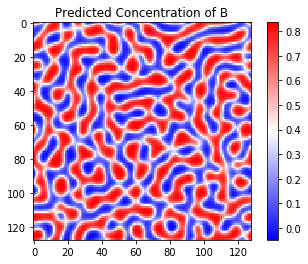

In [90]:
plt.imshow(u_pred,cmap='bwr')
plt.title('Predicted Concentration of B')
plt.colorbar()
plt.show()

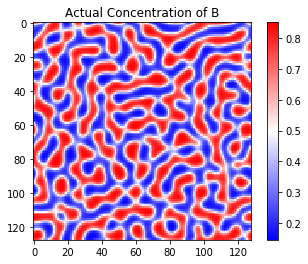

In [88]:
plt.imshow(u,cmap='bwr')
plt.title('Actual Concentration of B')
plt.colorbar()
plt.show()

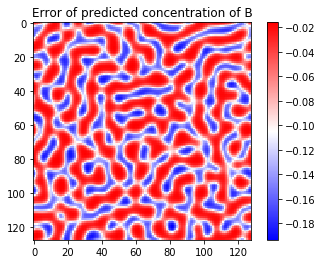

In [87]:
plt.imshow(u_pred-u,cmap='bwr')
plt.title('Error of predicted concentration of B')
plt.colorbar()
plt.show()